In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optiml
import torch.optim as optim
import torch.utils.data as data_utils

from torch.utils.data.dataset import Dataset
import torch.utils
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb

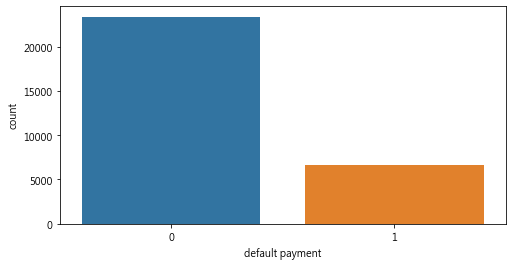

In [2]:
data = pd.read_csv('./UCI_Credit_Card.csv')
data.rename(columns={'default.payment.next.month':'target'}, inplace=True)
data.target.unique()
plt.figure(figsize=(8,4))
sb.countplot(x='target', data = data)
plt.xlabel('default payment')
plt.ylabel('count')
plt.show()

In [3]:
torch.manual_seed(1)    

num_epochs = 20         
bs = 128
lr = 0.02          
nw = 4
tp = 3
imbalance = 0

In [4]:
def normalize(df):
    for col in df.columns:
        if(col == 'target'):
            continue
        else:
            if(df[col].std() > 1000):
                df[col] = (df[col] - df[col].mean()) / df[col].std()
            else:
                df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
    
    return df


In [8]:
# type 1
if(tp == 1):
    data = pd.read_csv('./UCI_Credit_Card.csv')
    data_1 = data[['PAY_0', 'PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6','default.payment.next.month']]
    data_1.rename(columns={'default.payment.next.month':'target'}, inplace=True)
    data_train = data_1[:25000]
    data_test = data_1[25000:]
    x_train = np.array(data_train.drop('target', axis = 1))
    y_train = np.array(data_train['target'])
    x_test = np.array(data_test.drop('target', axis = 1))
    y_test = np.array(data_test['target'])
    #target : default payment(違約金) 1:違約 0:沒違約
    input_feature = 18
    data_1[:10]

In [9]:
# type 2
if(tp == 2):

    data_ = pd.read_csv('./UCI_Credit_Card.csv')
    data2 = data_[['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6','default.payment.next.month']]
    data_2 = data_
    data_2.rename(columns={'default.payment.next.month':'target'}, inplace=True)
    data_2['D5'] = (data2['PAY_AMT5'] / data2['BILL_AMT6'])*100
    data_2['D4'] = (data2['PAY_AMT4'] / data2['BILL_AMT5'])*100
    data_2['D3'] = (data2['PAY_AMT3'] / data2['BILL_AMT4'])*100
    data_2['D2'] = (data2['PAY_AMT2'] / data2['BILL_AMT3'])*100
    data_2['D1'] = (data2['PAY_AMT1'] / data2['BILL_AMT2'])*100
    data_2 = data_2[['D1','D2','D3','D4','D5','target']]
    data_2.fillna(100,inplace=True)


    data_2 = data_2[data_2['D5']>=0]
    data_2 = data_2[data_2['D4']>=0]
    data_2 = data_2[data_2['D3']>=0]
    data_2 = data_2[data_2['D2']>=0]
    data_2 = data_2[data_2['D1']>=0]
    data_2 = data_2.reset_index()
    data_2 = data_2.drop(['index'],axis=1)


    data_train = data_2[:25000]
    data_test = data_2[25000:]
    x_train = np.array(data_train.drop('target', axis = 1))
    y_train = np.array(data_train['target'])
    x_test = np.array(data_test.drop('target', axis = 1))
    y_test = np.array(data_test['target'])
    input_feature = 5
    print(len(data_2))
    print(data_2[:10])

In [10]:
# type 3
if(tp == 3):
    data_ = pd.read_csv('./UCI_Credit_Card.csv')
    data3 = data_[['LIMIT_BAL','SEX','EDUCATION','MARRIAGE','AGE','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6','default.payment.next.month']]
    data_3 = data_
    data_3.rename(columns={'default.payment.next.month':'target'}, inplace=True)
    data_3['D5'] = (data3['PAY_AMT5'] - data3['BILL_AMT6']) / data3['LIMIT_BAL']
    data_3['D4'] = (data3['PAY_AMT4'] - data3['BILL_AMT5']) / data3['LIMIT_BAL']
    data_3['D3'] = (data3['PAY_AMT3'] - data3['BILL_AMT4']) / data3['LIMIT_BAL']
    data_3['D2'] = (data3['PAY_AMT2'] - data3['BILL_AMT3']) / data3['LIMIT_BAL']
    data_3['D1'] = (data3['PAY_AMT1'] - data3['BILL_AMT2']) / data3['LIMIT_BAL']
    data_3 = data_3[['D1','D2','D3','D4','D5','LIMIT_BAL','SEX','EDUCATION','MARRIAGE','AGE','target']]
    data_3 = data_3[data_3['EDUCATION']<=3]
    data_3 = data_3.reset_index()
    data_3 = data_3.drop(['index'],axis=1)
    data_3 = normalize(data_3)

    if(imbalance == 1):
        data_3 = data_3.sort_values(by=['target'],ascending=False)
        data_3 = data_3[:14000]
        split_point = 10000    
        data_3.target.unique()
        plt.figure(figsize=(8,4))
        sb.countplot(x='target', data = data_3)
        plt.xlabel('default payment')
        plt.ylabel('count')
        plt.show()
    else:
        split_point = 25000
   
    data_train = data_3[:split_point]
    data_test = data_3[split_point:]
    x_train = np.array(data_train.drop('target', axis = 1))
    y_train = np.array(data_train['target'])
    x_test = np.array(data_test.drop('target', axis = 1))
    y_test = np.array(data_test['target'])
    input_feature = 10
    print(len(data_3))
    print(data_3[:10])


29546
         D1        D2        D3        D4        D5  LIMIT_BAL  SEX  \
0  0.717360  0.599922  0.712978  0.610021  0.712475  -1.133896  1.0   
1  0.734173  0.598307  0.710274  0.607403  0.707299  -0.364051  1.0   
2  0.719285  0.584490  0.691818  0.590186  0.681684  -0.595004  1.0   
3  0.625419  0.491033  0.635510  0.538709  0.603989  -0.902943  1.0   
4  0.727121  0.601870  0.681721  0.584050  0.642221  -0.902943  0.0   
5  0.605501  0.471405  0.659444  0.562361  0.640004  -0.902943  0.0   
6  0.650582  0.506630  0.568792  0.491565  0.537166   2.561363  0.0   
7  0.735890  0.599922  0.712663  0.610969  0.714608  -0.518020  1.0   
8  0.726702  0.589961  0.700959  0.600154  0.708776  -0.210081  1.0   
9  0.735890  0.599922  0.712978  0.610021  0.590667  -1.133896  0.0   

   EDUCATION  MARRIAGE       AGE  target  
0   0.666667  0.333333  0.051724       1  
1   0.666667  0.666667  0.086207       1  
2   0.666667  0.666667  0.224138       0  
3   0.666667  0.333333  0.275862       0

In [11]:
data_3['target'].sum() #29546 - 6603 = 222943

6603

In [12]:


x_train = torch.from_numpy(x_train).reshape(-1,input_feature,1).type(torch.FloatTensor)
y_train = torch.from_numpy(y_train.astype(np.float64)).view(-1,1).type(torch.FloatTensor)
x_test = torch.from_numpy(x_test).reshape(-1,input_feature,1).type(torch.FloatTensor)
y_test = torch.from_numpy(y_test.astype(np.float64)).view(-1,1).type(torch.FloatTensor)
y_train = y_train.long()
y_test = y_test.long()
#train_target = torch.tensor(data_train['default.payment.next.month'],dtype=torch.long)
#train = torch.tensor(data_train.drop('default.payment.next.month', axis = 1).values.astype(np.float64))
#test_target = torch.tensor(data_test['default.payment.next.month'].values.astype(np.float64))
#test = torch.tensor(data_test.drop('default.payment.next.month', axis = 1).values.astype(np.float64))


train_data = data_utils.TensorDataset(x_train, y_train)
test_data = data_utils.TensorDataset(x_test, y_test)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

train_loader = data_utils.DataLoader(
    dataset = train_data,
    batch_size = bs,
    shuffle = True,
    num_workers = nw,
)

test_loader = data_utils.DataLoader(
    dataset = test_data,
    batch_size = 200,
    shuffle = True,
    num_workers = nw,
)


torch.Size([25000, 10, 1]) torch.Size([25000, 1])
torch.Size([4546, 10, 1]) torch.Size([4546, 1])


In [13]:
def acc_cal(predict,label):
    l = len(predict)
    acc_count = 0
    count = 0
    for i in range(l):
        if(torch.argmax(output[i])==label[i]):
            acc_count = acc_count + 1
        count = count + 1
    return acc_count,count

#重置參數用
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

In [22]:
"""

import torch.nn.functional as F     

class Net(torch.nn.Module):     
    def __init__(self):
        super(Net, self).__init__()     
        self.hidden = torch.nn.Linear(input_feature, 36)   
        self.out = torch.nn.Linear(36, 2)       

    def forward(self, x):
        
        x = F.relu(self.hidden(x))      
        x = self.out(x)                 
        return x

dnn = Net() 
print(dnn)  
"""

class DNN(torch.nn.Module):     
    def __init__(self):
        super(DNN, self).__init__()
        self.dnn1 = nn.Sequential(
            nn.Linear(input_feature,36, bias = True),
            #nn.Dropout(0.5),
            nn.ReLU()
        )  
        
        self.dnn2 = nn.Sequential(  
            nn.Linear(36,108, bias = True),
            nn.Dropout(0.8),
            nn.ReLU()
        )
        
        self.dnn3 = nn.Sequential(  
            nn.Linear(108,2, bias = True),
            #nn.Dropout(0.5),
            #nn.Softmax()
            #nn.Sigmoid()
            #nn.ReLU()
        )
    def forward(self, x):
        
        x_1 = self.dnn1(x)
        x_2 = self.dnn2(x_1)   
        output = self.dnn3(x_2)               
        return output
    
dnn = DNN() 
print(dnn)  

DNN(
  (dnn1): Sequential(
    (0): Linear(in_features=10, out_features=36, bias=True)
    (1): ReLU()
  )
  (dnn2): Sequential(
    (0): Linear(in_features=36, out_features=108, bias=True)
    (1): Dropout(p=0.8, inplace=False)
    (2): ReLU()
  )
  (dnn3): Sequential(
    (0): Linear(in_features=108, out_features=2, bias=True)
  )
)


In [25]:
optimizer = torch.optim.Adam(dnn.parameters(), lr=lr)  
#optimizer = torch.optim.SGD(dnn.parameters(), lr=0.1, momentum=0.9)
loss_func = nn.CrossEntropyLoss() 
#loss_func = nn.BCEWithLogitsLoss() 

dnn.apply(weight_reset)

for epoch in range(num_epochs):
    acc_count_t = 0
    count_t = 0
    acc_count_t_test = 0
    count_t_test = 0    
    for iteration, (b_x, b_y) in enumerate(train_loader):   
        b_x = b_x.view(-1, input_feature)
        b_y = b_y.squeeze()
        #print(b_y)
        output = dnn(b_x)               
        loss = loss_func(output, b_y)  
        #print(output)
        optimizer.zero_grad()           
        loss.backward()                 
        optimizer.step()                
        acc_count,count = acc_cal(output,b_y)
        acc_count_t = acc_count_t + acc_count
        count_t = count_t + count
        acc = acc_count_t / count_t
        """
        if(iteration == 1):
            acc1 = acc
        """
    for iteration, (b_x_test, b_y_test) in enumerate(test_loader):
        if(iteration == 10):
            break
        b_x_test = b_x_test.view(-1, input_feature)
        b_y_test = b_y_test.squeeze()
        output = dnn(b_x_test) 
        acc_count,count = acc_cal(output,b_y_test)
        acc_count_t_test = acc_count_t_test + acc_count
        count_t_test = count_t_test + count
    acc_test = acc_count_t_test / count_t_test
    
    print('acc_count_t_test',acc_count_t_test)
    print('count_t_test',count_t_test)
    print ('Epoch [{}/{}] , Loss: {:.4f} , Train_Acc: {:.4f}  , Test_Acc: {:.4f}' 
           .format(epoch+1, num_epochs, loss, acc, acc_test))

acc_count_t_test 1576
count_t_test 2000
Epoch [1/20] , Loss: 0.6087 , Train_Acc: 0.6793  , Test_Acc: 0.7880
acc_count_t_test 1561
count_t_test 2000
Epoch [2/20] , Loss: 0.4853 , Train_Acc: 0.7747  , Test_Acc: 0.7805
acc_count_t_test 1551
count_t_test 2000
Epoch [3/20] , Loss: 0.5416 , Train_Acc: 0.7748  , Test_Acc: 0.7755
acc_count_t_test 1600
count_t_test 2000
Epoch [4/20] , Loss: 0.5226 , Train_Acc: 0.7749  , Test_Acc: 0.8000
acc_count_t_test 1572
count_t_test 2000
Epoch [5/20] , Loss: 0.6506 , Train_Acc: 0.7749  , Test_Acc: 0.7860
acc_count_t_test 1563
count_t_test 2000
Epoch [6/20] , Loss: 0.5382 , Train_Acc: 0.7749  , Test_Acc: 0.7815
acc_count_t_test 1574
count_t_test 2000
Epoch [7/20] , Loss: 0.5421 , Train_Acc: 0.7749  , Test_Acc: 0.7870
acc_count_t_test 1562
count_t_test 2000
Epoch [8/20] , Loss: 0.6409 , Train_Acc: 0.7749  , Test_Acc: 0.7810
acc_count_t_test 1567
count_t_test 2000
Epoch [9/20] , Loss: 0.5315 , Train_Acc: 0.7749  , Test_Acc: 0.7835
acc_count_t_test 1564
count_

In [214]:
num_epochs = 30

In [24]:
lr = 0.0001